In [1]:
import numpy as np
from tqdm import tqdm
import math
import os

import keras
from keras.models import *
from keras.layers import *
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
from keras.applications.densenet import DenseNet121
from keras.callbacks import *
from keras import backend as K
import itertools
import matplotlib.pyplot as plt
import cv2

from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


In [2]:
covid_path = '/kaggle/input/kaggle-covid-xray/kaggle_covid/covid/'
covid_files = os.listdir(covid_path)
#covid_files.remove('.DS_Store')

labels_covid = []
data_covid = []

for file in tqdm(covid_files):
    imagePath = covid_path + file
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data_covid.append(image)
    labels_covid.append('covid')


100%|██████████| 76/76 [00:03<00:00, 24.65it/s]


In [3]:
pne_path = '/kaggle/input/kaggle-covid-xray/kaggle_covid/pneumonia/'
pne_files = os.listdir(pne_path)
#norm_files.remove('.DS_Store')

labels_pne = []

data_pne = []

for file in tqdm(pne_files):
    imagePath = pne_path + file
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data_pne.append(image)
    labels_pne.append('pneum')


100%|██████████| 100/100 [00:01<00:00, 85.70it/s]


In [ ]:
norm_path = '/kaggle/input/kaggle-covid-xray/kaggle_covid/normal/'
norm_files = os.listdir(norm_path)
#norm_files.remove('.DS_Store')

labels_norm = []

data_norm = []

for file in tqdm(norm_files):
    imagePath = norm_path + file
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data_norm.append(image)
    labels_norm.append('normal')


In [ ]:
# data = data_covid + data_pne + data_norm
# labels = labels_covid + labels_pne + labels_norm

In [4]:
def step_decay(epoch):
    initial_lrate=0.001
    drop=0.1
    epochs_drop=10
    lrate=initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); print(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.2, 
                                                  random_state=42)



In [ ]:
lb.classes_


In [ ]:
lb.inverse_transform([0,1,2])

In [ ]:
lr=keras.callbacks.LearningRateScheduler(step_decay,verbose=1)


trainAug = ImageDataGenerator(rotation_range=15,
                              fill_mode="nearest")



In [ ]:
len(trainX)

#### Transfer Learning

In [ ]:
#### Downloading the Pre-trained Model
#mobnet_model = keras.applications.mobilenet.MobileNet()

In [5]:
baseModel = keras.applications.VGG16(weights="imagenet", 
                                     include_top= False,
                                     input_tensor=Input(shape=(224, 224, 3)))


58892288/58889256 [==============================] - 5s 0us/step


In [6]:
baseModel.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers[:-2]:
    layer.trainable = False

In [ ]:
lr_opt = 6e-4
epochs = 10
batch_size = 8

In [ ]:
opt = Adam(lr=lr_opt, decay= lr_opt / epochs)


model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])


In [ ]:
model.summary()

In [ ]:
#lr=keras.callbacks.LearningRateScheduler(step_decay,verbose=1)
lr=keras.callbacks.LearningRateScheduler(step_decay,verbose=1)

In [ ]:
checkpoint= keras.callbacks.ModelCheckpoint('./Checkpoint_normal', monitor='val_acc', 
                                               verbose=0, save_best_only=True, 
                                               save_weights_only=False, 
                                               mode='auto',
                                               period=1)

In [ ]:
print("[INFO] training head...")

history = model.fit_generator(
                trainAug.flow(np.array(trainX), np.array(trainY), batch_size=batch_size),
                steps_per_epoch=len(trainX) // batch_size,
                validation_data=(np.array(testX), np.array(testY),),
                validation_steps=len(testX) // batch_size,
                callbacks=[checkpoint,lr],
                epochs=epochs)

In [ ]:
#Plotting
plt.figure()
plt.plot(np.arange(0, 10), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
plt.title("Plotting Loss and Accuracy on COVID-19 Image Dataset")
plt.xlabel("No of epochs")
plt.ylabel("Loss&Accyracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

In [ ]:
predIdxs = model.predict(np.array(testX), batch_size=8)
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
predIdxs

In [ ]:
testY.argmax(axis=1)

In [ ]:
import sklearn
print(sklearn.metrics.confusion_matrix(testY.argmax(axis=1), predIdxs))

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=['covid', 'normal', 'pneum']))

In [ ]:
model.save("/kaggle/working/model_covid_vs_pneumonia_vs_normal.h5")

In [8]:
from keras.models import load_model
 
# load model
model = load_model('/kaggle/input/model-pneumonia-vs-covidh5/model_pneumonia_vs_covid.h5')

In [9]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Class Activation Map

In [ ]:
# img_path = norm_path + norm_files[0]
# norm_img = cv2.imread(img_path)
# norm_img = cv2.cvtColor(norm_img, cv2.COLOR_BGR2RGB)
# norm_img = cv2.resize(norm_img, (224, 224))
# norm_img = np.expand_dims(norm_img,axis=0)

In [10]:
def get_class_activation_map(ind,path,files) :
    
    img_path =  path + files[ind]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img,axis=0)
    
    predict = model.predict(img)
    target_class = np.argmax(predict[0])
    last_conv = model.get_layer('block5_conv3')
    grads = K.gradients(model.output[:,target_class],last_conv.output)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
    pooled_grads_value,conv_layer_output = iterate([img])
    
    for i in range(512):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output,axis=-1)
    
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    plt.imshow(heatmap)
#     output_path_heatmap = '/kaggle/working/output_images/' + files[ind] + 'heatmap.jpeg'
#     plt.imsave(output_path_heatmap,heatmap)
    
    img_gray = cv2.cvtColor(img[0], cv2.COLOR_BGR2GRAY)
    upsample = cv2.resize(heatmap, (224,224))
    # plt.imshow(upsample,alpha=0.5)
    # plt.imshow(img_gray)
    #plt.imshow(upsample * img_gray)
    output_path_gradcam = '/kaggle/working/' + files[ind] + 'gradcam.jpeg'
    plt.imsave(output_path_gradcam,upsample * img_gray)
    
    #plt.show()
    
    #return img

In [20]:
path = pne_path
files = pne_files

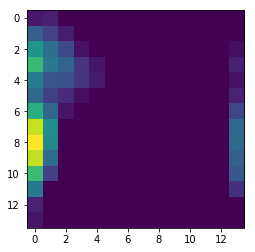

In [26]:
get_class_activation_map(5,path,files)

In [25]:
path + files[5]

'/kaggle/input/kaggle-covid-xray/kaggle_covid/pneumonia/person1395_bacteria_3544.jpeg'

In [ ]:
# import shutil
# shutil.rmtree('/kaggle/working/output_images/')
os.remo

In [ ]:
np.arange(0,11)

In [ ]:
# img_path = covid_path + covid_files[1]
# covid_img = cv2.imread(img_path)
# covid_img = cv2.cvtColor(covid_img, cv2.COLOR_BGR2RGB)
# covid_img = cv2.resize(covid_img, (224, 224))
# covid_img = np.expand_dims(covid_img,axis=0)

In [ ]:
#norm_img.shape

In [ ]:
#covid_img.shape

In [ ]:
#predict = model.predict(norm_img)
# print(decode_predictions(predict,top=3))
# target_class = np.argmax(predict[0])

In [ ]:
predict = model.predict(norm_img)

In [ ]:
predict

In [ ]:
# target_class = np.argmax(predict[0])
# target_class

In [ ]:
#print("Target Class is covid")

In [ ]:
#last_conv = model.get_layer('block5_conv3')

In [ ]:
#grads = K.gradients(model.output[:,0],last_conv.output)[0]

In [ ]:
# pooled_grads = K.mean(grads,axis=(0,1,2))
# iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
# pooled_grads_value,conv_layer_output = iterate([covid_img])

In [ ]:
# for i in range(512):
#     conv_layer_output[:,:,i] *= pooled_grads_value[i]
# heatmap = np.mean(conv_layer_output,axis=-1)

In [ ]:
# for x in range(heatmap.shape[0]):
#     for y in range(heatmap.shape[1]):
#         heatmap[x,y] = np.max(heatmap[x,y],0)

In [ ]:
# heatmap = np.maximum(heatmap,0)
# heatmap /= np.max(heatmap)
# plt.imshow(heatmap)

In [ ]:
#img_gray = cv2.cvtColor(norm_img[0], cv2.COLOR_BGR2GRAY)

In [ ]:
upsample = cv2.resize(heatmap, (224,224))
# plt.imshow(upsample,alpha=0.5)
# plt.imshow(img_gray)
plt.imshow(upsample * img_gray)
plt.show()

In [ ]:
upsample = cv2.resize(heatmap, (224,224))
# plt.imshow(upsample,alpha=0.5)
# plt.imshow(img_gray)
plt.imshow(upsample * img_gray)
plt.show()